# Using emcee to model the light curves from Kepler-10

Kepler-10 is a star located roughly 608 lightyears from Earth. Kepler-10 was targeted by NASA in their search for an Earth-like exoplanet, and in 2011 the first exoplanet orbiting Kepler-10 was discovered. The planet, Kepler-10b, is a rocky planet with 1.4x the radius of Earth, and 3.7x the mass.

As Kepler-10b passes infront of its star, it obstructs some flux (the light energy per unit time per unit area) from the star, casting a shadow towards Earth. We see this as a slight periodic dip in light intesity, occuring every time the exoplanet is infront of its star. This is called a "transit detection method", and can be used to infer the existense of an exoplanet, but also to find the properties of the star-planet system.

In this example, I will create a model describing the flux of a star with, a single orbiting planet, as a function of time. I will then use the "emcee" sampler to fit the model parameters to some real Kepler-10 light curve data, provided by NASA.

### Useful imports:

In [1]:
# numpy
import numpy as np

# scipy
from scipy.special import gammaln
from scipy.stats import gaussian_kde

# astropy
from astropy.io import fits
from astropy.table import Table

# plotting
import corner
from matplotlib import pyplot as plt
%matplotlib inline

# sampler
import emcee as mc
print(mc.__version__)

# misc
from time import time as timer

3.0.3.dev4+gc14b212


### Viewing the data:

Light curve models can vary from simple square shaped transits, to extremely complicated transits involving limb-darkening and other effects. To decide which model is most appropriate, we need to first see the data we will be using.

The light curve data is in the form of a FITS file. These files can be easily loaded into a Table format (simillar to a Pandas DataFrame) using astropy. The data is quite large, so I chose to look at the first 1325 data points only. Whilst extracting the data, any data points with a flux of "nan" need to be removed from both the "flux" and "time" lists.

In [2]:
table = fits.open("kplr011904151-2010265121752_llc.fits")
tab = table[1]
data = Table(tab.data)

flux_orig = data['PDCSAP_FLUX'][:1325]
time_orig = data['TIME'][:1325]
ind_nan = [i for i in range(len(flux_orig)) if str(flux_orig[i]) == "nan"]
flux = [flux_orig[i] for i in range(len(flux_orig)) if i not in ind_nan]
time = [time_orig[i] for i in range(len(time_orig)) if i not in ind_nan]

Now, we can plot the light curve we will be using and decide how complicated our model needs to be. Of the two plots below, the first shows the whole light curve that I'll be using, and the second shows a "zoomed in" segment of the light curve. 

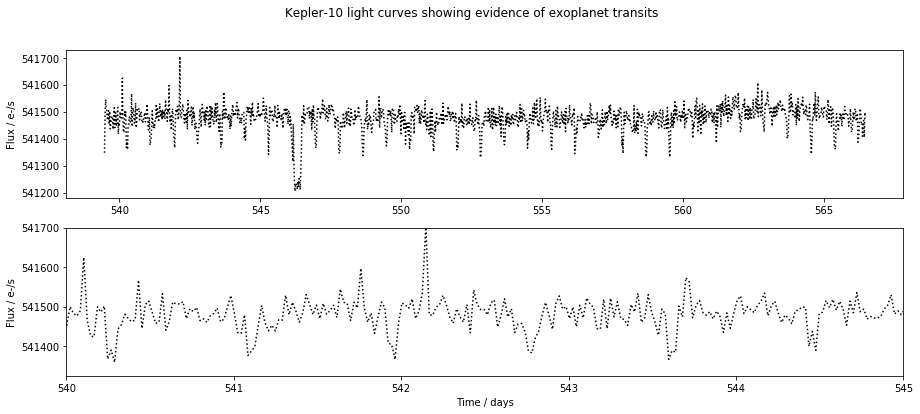

In [3]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,6))
# plot all useful data
ax1.plot(time, flux, "k:")
ax1.set_ylabel("Flux / e-/s")

# plot zoomed in view of transits
ax2.plot(time, flux, "k:")
ax2.set_ylabel("Flux / e-/s")
ax2.set_xlabel("Time / days")
ax2.set_ylim(541325, 541700)
ax2.set_xlim(540, 545)

plt.suptitle("Kepler-10 light curves showing evidence of exoplanet transits")
plt.show()

The above plot shows regular dips in flux, as expected from exoplanet transits. The dips appear to be "V-shaped", with sloped sides and a flat bottom. This suggests we could use a model of regular trapezium shaped flux drops. However, the slopes are fairly steep, so we could also use a much simpler square shaped flux drop instead. This would save on time, but may come at the cost of accuracy.

### The model:

Below is a diagram showing which parameters are needed to define a trapezium shaped transit (left), and how I will go about modelling the model in Python (right). I started with a simple recurring step function, then modified the step to have the triangular shape with height "h", which can be calculated using basic trigonometry. Finally, I added a hard floor at a flux change of df, to create the trapezium shape. The square wave shape is simillar, but tt and tf are equal.

![alt text](transits.png "Title")

Using this, I defined a the function that will be used to model the transit:

In [4]:
def transit(time, f, df, p, tt, tf=None, off=0, square=False):
    """
    Flux, from a uniform star source with single orbiting planet, as a function of time
    :param time: 1D array, input times
    :param f: unobscured flux, max flux level
    :param df: ratio of obscured to unobscured flux
    :param p: period of planet's orbit
    :param tt: total time of transit
    :param tf: time during transit in which flux doesn't change
    :param off: time offset. A value of 0 means the transit begins immidiately
    :param square: If True, the shape of the transit will be square (tt == tf)
    :return: 1D array, flux from the star
    """ 
    if tf is None:
        tf = tt
    if tt <= tf:
        # Default to square shaped transit 
        square = True
        
    y = []
    if not square:
        # define slope of sides of trapezium 
        h = f*df*tt/(tt-tf)
        grad = 2*h/tt
        
    for i in time:
        j = (i + off) % p
        if j < tt:
            # transit
            # square shaped transit
            if square:
                y.append(f*(1 - df))
                
            # trapezium shaped transit
            elif j/tt < 0.5:
                # first half of transit
                val = f - grad*j
                if val < f*(1 - df):
                    y.append(f*(1 - df))
                else:
                    y.append(val)
            else:
                # last half of transit
                val = (grad*j) - 2*h + f
                if val < f*(1 - df):
                    y.append(f*(1 - df))
                else:
                    y.append(val)
        else:
            # no transit
            y.append(f)
    return y

I'll be using both a trapezium and square shape transit in tandem throughout this example, and I'll compare the performance and accuracies of both models.

Now that we know the parameters that will describe the model, we can start guessing at the parameter priors by using the plots above. Since the square transit model does not require the "tf" parameter, we can omit it from the list of square transit priors for a little extra time save. This model is quite complicated with six parameters, and eyeballing the values of each parameter can be tricky. Using a little trial and error, I came up with the following guesses:

In [5]:
f_mu = 541500
f_sig = 50

df_mu = 2.5e-4
df_sig = 0.1e-4

p_mu = 0.8376
p_sig = 0.008

tt_mu = 0.15
tt_sig = 0.02

tf_mu = 0.05
tf_sig = 0.005

off_mu = 0.1451
off_sig = 0.001

priors = [(f_mu, f_sig), (df_mu, df_sig), (p_mu, p_sig),
          (tt_mu, tt_sig), (tf_mu, tf_sig), (off_mu, off_sig)]
# remove tf for square transit parameters
priors_square = priors[:4] + priors[5:]

### Sampling the data:

The "emcee" sampler requires the user to provide a prior, likelihood, and posterior function, all in their log forms. These functions are very simillar for the trapezium and square shaped transit models; the key difference being the "tf" parameter is omitted for the square model. Since I decided on using Normal priors for each parameter, The log of the prior takes the following forms:

In [6]:
def logprior(theta):
    """
    Function to return the log of the prior for a trapezium shaped transit light curve model
    :param theta: tuple or list containing each parameter
    """
    lprior = 0
    for i in range(len(priors)):
        # sum log priors from each parameter
        lprior -= 0.5*((theta[i] - priors[i][0]) / priors[i][1])**2
    return lprior

def logprior_square(theta):
    """
    Function to return the log of the prior for a square shaped transit light curve model
    :param theta: tuple or list containing each parameter
    """
    lprior = 0
    for i in range(len(priors_square)):
        # sum log priors from each parameter
        lprior -= 0.5*((theta[i] - priors_square[i][0]) / priors_square[i][1])**2
    return lprior

The likelihood takes the form of a Poisson distribution, since flux is a non-negative quantity. The expected value of the likelihood "lmbda" is found using the "step" function defined above.

In [7]:
def loglike(theta, obs, times):
    """
    Function to return the log likelihood of the trapezium shpaed transit light curve model
    :param theta: tuple or list containing each parameter
    :param obs: list or array containing the observed flux of each data point
    :param times: list or array containing the times at which each data point is recorded
    """
    # unpack parameters
    f_like, df_like, p_like, tt_like, tf_like, off_like = theta
    # expected value
    lmbda = np.array(transit(times, f_like, df_like, p_like, tt_like, tf_like, off=off_like))
    n = len(obs)
    a = np.sum(gammaln(np.array(obs)+1))
    b = np.sum(np.array(obs) * np.log(lmbda))
    return -np.sum(lmbda) - a + b

def loglike_square(theta, obs, times):
    """
    Function to return the log likelihood of the square shpaed transit light curve model
    :param theta: tuple or list containing each parameter
    :param obs: list or array containing the observed flux of each data point
    :param times: list or array containing the times at which each data point is recorded
    """
    # unpack parameters
    f_like, df_like, p_like, tt_like, off_like = theta
    # expected value
    lmbda = np.array(transit(times, f_like, df_like, p_like, tt_like, off=off_like, square=True))
    n = len(obs)
    a = np.sum(gammaln(np.array(obs)+1))
    b = np.sum(np.array(obs) * np.log(lmbda))
    return -np.sum(lmbda) - a + b

When using MCMC, the log posterior can be found as the sum of the log prior and log likelihood:

In [8]:
def logposterior(theta, obs, times):
    lprior = logprior(theta)
    # check log prior is finite
    if not np.isfinite(lprior):
        return -np.inf
    return lprior + loglike(theta, obs, times)

def logposterior_square(theta, obs, times):
    lprior = logprior_square(theta)
    # check log prior is finite
    if not np.isfinite(lprior):
        return -np.inf
    return lprior + loglike_square(theta, obs, times)

Next, we can start setting up the MCMC model. To start, I'll draw 200 "ensemble" sanples from each prior distribution, which will be used to represent the priors. I'll also define a 500 "burn-in" iterations to allow the chain to converge, and 500 further iterations to produce the posteriors.

In [9]:
# no. ensemble points
Nens = 200

inisamples = np.array([np.random.normal(priors[i][0], priors[i][1],
                                        Nens) for i in range(len(priors))]).T
inisamples_square = np.array([np.random.normal(priors_square[i][0], priors_square[i][1],
                                               Nens) for i in range(len(priors_square))]).T
ndims = inisamples.shape[1]
ndims_square = inisamples_square.shape[1]

# no. iterations
Nburn = 500
Nsamples = 500

loglike.ncalls = 0
loglike_square.ncalls = 0

Now that everything is set up, we can perform the sampling process:

In [10]:
sampler = mc.EnsembleSampler(Nens, ndims, logposterior, args=[flux, time])
sampler_square = mc.EnsembleSampler(Nens, ndims_square, logposterior_square, args=[flux, time])

# perform sampling
t0 = timer()
sampler.run_mcmc(inisamples, Nsamples+Nburn)
t1 = timer()
print("time taken to sample a trapezium transit model: {} seconds".format(t1-t0))
sampler_square.run_mcmc(inisamples_square, Nsamples+Nburn)
t2 = timer()
print("time taken to sample a square transit model: {} seconds".format(t2-t1))

time taken to sample a trapezium transit model: 157.8114993572235 seconds
time taken to sample a square transit model: 128.9720060825348 seconds


The burn-in points can be removed before collecting the chains as follows:

In [11]:
samples_trapez = sampler.chain[:, Nburn:, :].reshape((-1, ndims))
samples_square = sampler_square.chain[:, Nburn:, :].reshape((-1, ndims_square))

### Results:

Let's take a look at what we found. Looking at the trapezium model, we can plot the posteriors of each parameter, along with contour plots describing how one parameter may vary with any other. This can be done using "corner.py", and a scipy Gaussian KDE function.

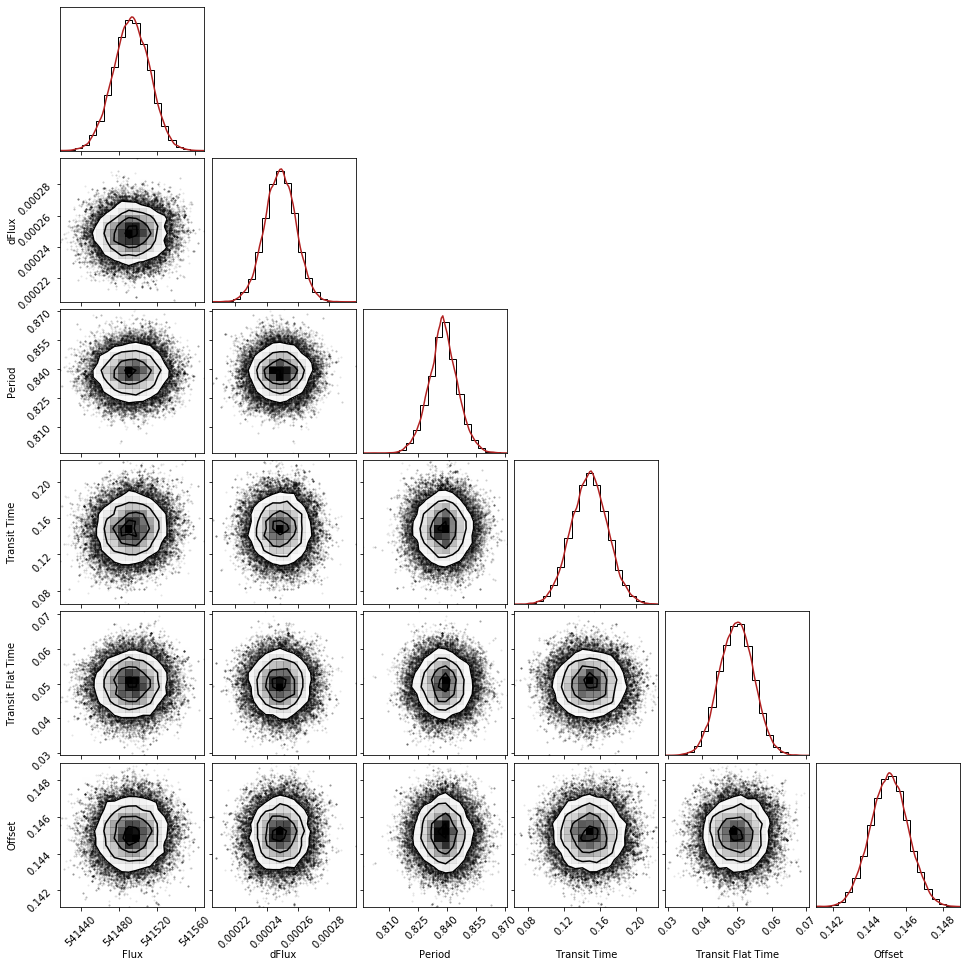

In [12]:
def plotposts(samples, labels, **kwargs):
    fig = corner.corner(samples, labels=labels, hist_kwargs={'density': True}, **kwargs)
    pos = [i*(len(labels)+1) for i in range(len(labels))]
    for axidx, samps in zip(pos, samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')
        
labels = ['Flux', 'dFlux', 'Period', 'Transit Time', 'Transit Flat Time', 'Offset']
plotposts(samples_trapez, labels)

Again using the trapezium model, the means and standard deviations of each parameter can be found as below:

In [13]:
f, ferr = np.mean(samples_trapez[:,0]), np.std(samples_trapez[:,0])
df, dferr = np.mean(samples_trapez[:,1]), np.std(samples_trapez[:,1])
p, perr = np.mean(samples_trapez[:,2]), np.std(samples_trapez[:,2])
tt, tterr = np.mean(samples_trapez[:,3]), np.std(samples_trapez[:,3])
tf, tferr = np.mean(samples_trapez[:,4]), np.std(samples_trapez[:,4])
off, offerr = np.mean(samples_trapez[:,5]), np.std(samples_trapez[:,5])

print("      Parameters describing a trapezium shaped transit model: \n \n" + 
      "       unobstructed flux = {} \u00B1 {} e-/s \n".format(f,ferr) + 
      "fractional flux decrease = {} \u00B1 {} \n".format(df,dferr) +
      "                  period = {} \u00B1 {} days \n".format(p,perr) + 
      "      total transit time = {} \u00B1 {} days \n".format(tt,tterr) +
      "       flat transit time = {} \u00B1 {} days \n".format(tf,tferr) + 
      "                  offset = {} \u00B1 {} days \n".format(off,offerr))

      Parameters describing a trapezium shaped transit model: 
 
       unobstructed flux = 541493.1279018042 ± 19.09579029804396 e-/s 
fractional flux decrease = 0.0002486061804035387 ± 9.905449555734231e-06 
                  period = 0.8381033169419388 ± 0.007619685953525794 days 
      total transit time = 0.1483650185186099 ± 0.020176842263708968 days 
       flat transit time = 0.04984355795377257 ± 0.004903631954233766 days 
                  offset = 0.1450860730604079 ± 0.0010214056184634926 days 



The same can be done for the square transit model:

In [14]:
f_square, ferr_square = np.mean(samples_square[:,0]), np.std(samples_square[:,0])
df_square, dferr_square = np.mean(samples_square[:,1]), np.std(samples_square[:,1])
p_square, perr_square = np.mean(samples_square[:,2]), np.std(samples_square[:,2])
tt_square, tterr_square = np.mean(samples_square[:,3]), np.std(samples_square[:,3])
off_square, offerr_square = np.mean(samples_square[:,4]), np.std(samples_square[:,4])

print("      Parameters describing a square shaped transit model: \n \n" + 
      "       unobstructed flux = {} \u00B1 {} e-/s \n".format(f_square,ferr_square) + 
      "fractional flux decrease = {} \u00B1 {} \n".format(df_square,dferr_square) +
      "                  period = {} \u00B1 {} days \n".format(p_square,perr_square) + 
      "      total transit time = {} \u00B1 {} days \n".format(tt_square,tterr_square) +
      "                  offset = {} \u00B1 {} days \n".format(off_square,offerr_square))

      Parameters describing a square shaped transit model: 
 
       unobstructed flux = 541498.4955687037 ± 19.434462141946803 e-/s 
fractional flux decrease = 0.0002481596234846456 ± 9.727555951942848e-06 
                  period = 0.8374007879135734 ± 0.007236698222041025 days 
      total transit time = 0.14426621119253685 ± 0.02052535527482306 days 
                  offset = 0.14507956732671926 ± 0.0009985213758789717 days 



The period in both cases is around 20 hours. This is unique to one body in the Kepler-10 system: Our model describes the transits of Kepler-10b.

### Plotting the posterior:

We can sample from the posteriors further to create slightly different sets of the parameters. From this, we can plot a new line over our original data, creating a posterior predictive plot. The regions in which the model is most likely to fall in will appear darker on the plot, and so the darker the plot, the higher the probabillity of the flux passing through it.

Start by randomly choosing 400 of each parameter for the trapezium and square models:

In [15]:
n_fits = 400

f_samps = np.random.choice(samples_trapez[:,0],n_fits)
df_samps = np.random.choice(samples_trapez[:,1],n_fits)
p_samps = np.random.choice(samples_trapez[:,2],n_fits)
tt_samps = np.random.choice(samples_trapez[:,3],n_fits)
tf_samps = np.random.choice(samples_trapez[:,4],n_fits)
off_samps = np.random.choice(samples_trapez[:,5],n_fits)

f_samps_square = np.random.choice(samples_square[:,0],n_fits)
df_samps_square = np.random.choice(samples_square[:,1],n_fits)
p_samps_square = np.random.choice(samples_square[:,2],n_fits)
tt_samps_square = np.random.choice(samples_square[:,3],n_fits)
off_samps_square = np.random.choice(samples_square[:,4],n_fits)

Below are two plots of the results of the MCMC algorithm. The first shows the entire original light curve data set, with a model with mean parameters plotted on top. The second shows a "zoomed in" view of a few exoplanet transits, with the posterior predictive overplotted. 

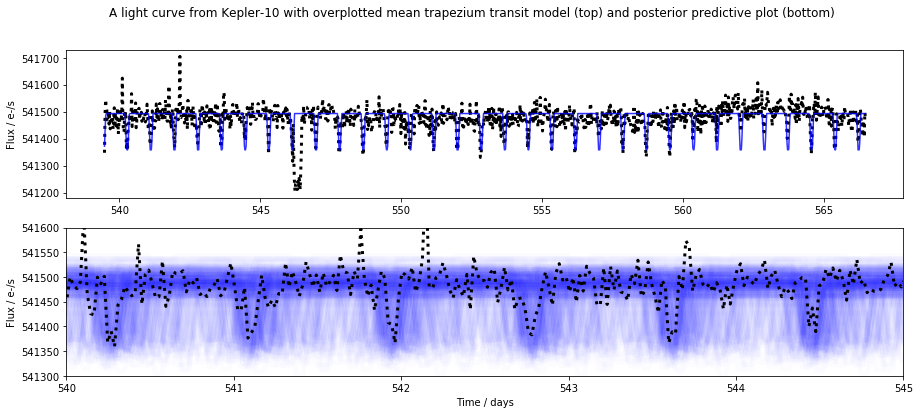

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,6))

# mean plot
ax1.plot(time, flux, "k:", linewidth=3)
x = np.linspace(min(time), max(time), 1350)
y = transit(x,f,df,0.83775,tt,tf,off)
ax1.plot(x, y, "b-", alpha=0.8)
ax1.set_ylabel("Flux / e-/s")

# posterior predictive plot
for i in range(n_fits):
    y = transit(x, f_samps[i], df_samps[i], p_samps[i], tt_samps[i], tf_samps[i], off_samps[i])
    ax2.plot(x, y, "b-", alpha=0.01, linewidth=5)
ax2.plot(time, flux, "k:", linewidth=3)
ax2.set_ylabel("Flux / e-/s")
ax2.set_xlabel("Time / days")
ax2.set_ylim(541300, 541600)
ax2.set_xlim(540, 545)

plt.suptitle("A light curve from Kepler-10 with overplotted" +
             " mean trapezium transit model (top) and posterior predictive plot (bottom)")
plt.show()

The same process can be repeated for the square transit model:

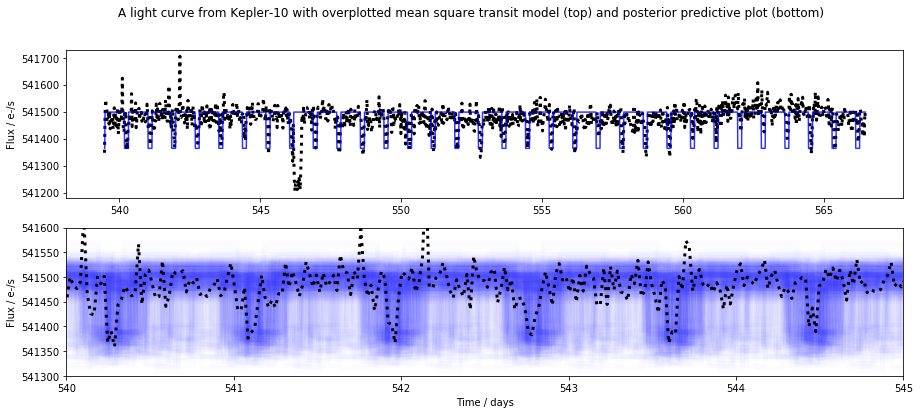

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15,6))

# mean plot
ax1.plot(time, flux, "k:", linewidth=3)
x = np.linspace(min(time), max(time), 3000)
y = transit(x,f_square,df_square,p_square,tt_square,off=off_square-0.2)
ax1.plot(x, y, "b-", alpha = 0.8)
ax1.set_ylabel("Flux / e-/s")

# posterior predictive plot
for i in range(n_fits):
    y = transit(x, f_samps_square[i], df_samps_square[i], p_samps_square[i],
             tt_samps_square[i], off=off_samps_square[i])
    ax2.plot(x, y, "b-", alpha=0.01, linewidth=5)
ax2.plot(time, flux, "k:", linewidth=3)
ax2.set_ylabel("Flux / e-/s")
ax2.set_xlabel("Time / days")
ax2.set_ylim(541300, 541600)
ax2.set_xlim(540, 545)

plt.suptitle("A light curve from Kepler-10 with overplotted" +
             " mean square transit model (top) and posterior predictive plot (bottom)")
plt.show()

Its fairly obvious from the posterior predictive plots that the trapezium shaped transit model is quite a lot better at explaining the observed data, since the darker regions of the plot are much narrower, and follow the shape of the transit data more accurately.

Even so, the mean plots for both models fit the data quite nicely, so I won't dismiss the square transit model just yet.

### Model comparisons:

Now that we have the mean values for each parameter, we can start to infer information about the star-planet system the model describes. I'll use both models for this, and find out which model predicts the properties the system with the greatest accuracy.

The first property we can find is the ratio of the planet radius "Rp" and star radius "Rs". This is simply the square root of the mean flux drop:

In [18]:
RpRs, RpRs_err = np.sqrt(df), dferr/(np.sqrt(df))
RpRs_square, RpRs_square_err = np.sqrt(df_square), dferr_square/(np.sqrt(df_square))

print("Planet to star radius ratio (trapezium transit model): {} \u00B1 {}".format(RpRs, RpRs_err))
print("Planet to star radius ratio (square transit model): {} \u00B1 {}".format(
       RpRs_square, RpRs_square_err))
print("True planet to star radius ratio: " + str(0.0127))

Planet to star radius ratio (trapezium transit model): 0.01576725024864953 ± 0.000628229361462861
Planet to star radius ratio (square transit model): 0.015753082983487567 ± 0.0006175017272580424
True planet to star radius ratio: 0.0127


Both models are in close agreement with eachother, and are quite close to the true value of the planet to star radius ratio (to within the same order of magnitude). We only used a couple of transits, and under one month of data, so the difference between predicted and true ratios here are acceptable. 

Next, we can attempt to find the density of the star Kepler-10. This isn't quite possible for the square model, due to the total transit and flat transit times being equal. To account for this, I'll instead say the flat transit time is 99% of the total transit time, just to keep everything finite.

In [29]:
tf_square, tferr_square = 0.90*tt_square, 0.90*tterr_square

The calculations become pretty complex here, and error propagation becomes difficult. Instead, I'll approximate the errors, as we're mostly interested in the relative errors between the two models anyway. To begin, we start by approximating the semi-minor axis "b", and the normalised semi-major axis "aRs" as below: 

In [30]:
def semiminor(df,tt,tf):
    # return semi-minor axis, given model parameters
    numerator = (tt**2)*(1-np.sqrt(df))**2 - (tf**2)*(1+np.sqrt(df))**2
    denominator = (tt**2) - (tf**2)
    print(numerator, denominator)
    return np.sqrt(numerator / denominator)

def normsemimajor(df,p,tt,tf):
    # return normalised semi-major axis, given model parameters
    numerator = 2*p*(df)**(1/4)
    denominator = np.pi*np.sqrt(tt**2 - tf**2)
    return numerator / denominator

# semiminor for trapezium model
b_trap = semiminor(df, tt, tf)
b_trap_err = semiminor(df + dferr, tt, tf) - b_trap

# semiminor for square model
b_square = semiminor(df_square, tt_square, tf_square)
b_square_err = semiminor(df_square + dferr_square, tt_square, tf_square) - b_square

# # semimajor for trapezium model
aRs_trap = normsemimajor(df,p,tt,tf)
aRs_trap_err = normsemimajor(df+dferr,p+perr,tt+tterr,tf+tferr) - aRs_trap

# semimajor for square model
aRs_square = normsemimajor(df_square,p_square,tt_square,tf_square)
aRs_square_err = normsemimajor(df_square+dferr_square,p_square+perr_square,
                               tt_square+tterr_square,tf_square+tferr_square) - aRs_square

0.018760166430283762 0.01952779845053637
0.018745120718516927 0.01952779845053637
0.002768531236928558 0.003954420541451436
0.002745531358526985 0.003954420541451436


Using these values, the density of Kepler-10 can be calculated for each model:

In [31]:
def star_density(df,p,tt,b):
    # return density of star given model parameters
    G = 6.67408e-11
    wt = tt*np.pi/p
    # transform p from days to seconds
    p *= 86400
    numerator = 3*np.pi*( (1+np.sqrt(df))**2 - (b**2)*(1-np.sin(wt)**2) )**(3/2)
    denominator = ( G*p**2 )*( np.sin(wt)**2 )**(3/2)
    return numerator / denominator

# star density predicted by trapezium model
stard_trap = star_density(df,p,tt,b_trap)
stard_trap_err = star_density(df+dferr,p-perr,tt+tterr,b_trap+b_trap_err) - stard_trap

# star density predicted by square model
stard_square = star_density(df_square,p_square,tt_square,b_square)
stard_square_err = star_density(df_square+dferr_square,p_square-perr_square,
                                tt_square+tterr_square,b_square+b_square_err) - stard_square

print("Star density (trapezium transit model): {} \u00B1 {} $kg/m^3$".format(stard_trap, stard_trap_err))
print("Star density (square transit model): {} \u00B1 {} $kg/m^3$".format(stard_square, stard_square_err))
print("True star density: {} $kg/m^3$".format(1060))

Star density (trapezium transit model): 36.102968413548325 ± -1.6350955463357977 $kg/m^3$
Star density (square transit model): 73.43589620396877 ± -13.36369340832048 $kg/m^3$
True star density: 1060 $kg/m^3$
